In [1]:
!pip install --no-deps ../input/effdet-latestvinbigdata-wbf-fused/omegaconf-2.0.6-py3-none-any.whl
!pip install --no-deps ../input/effdet-latestvinbigdata-wbf-fused/timm-0.3.4-py3-none-any.whl
!pip install --no-deps ../input/effdet-latestvinbigdata-wbf-fused/pycocotools-2.0.2/
!pip install --no-deps ../input/efficientdetpytorch/
!pip install --no-deps ../input/effdet-latestvinbigdata-wbf-fused/ensemble_boxes-1.0.4-py3-none-any.whl

Processing /kaggle/input/effdet-latestvinbigdata-wbf-fused/omegaconf-2.0.6-py3-none-any.whl
Processing /kaggle/input/effdet-latestvinbigdata-wbf-fused/timm-0.3.4-py3-none-any.whl
Processing /kaggle/input/effdet-latestvinbigdata-wbf-fused/pycocotools-2.0.2
  Created wheel for pycocotools: filename=pycocotools-2.0.2-cp37-cp37m-linux_x86_64.whl size=272451 sha256=01a171de59c95382b00ea01c5e47fdac70e0ef8884fc9739b6b9c91e0d150aa8
  Stored in directory: /root/.cache/pip/wheels/77/f3/8e/c5e256e935b65c7d9549c41f53d04e33de2ba1a04637834b4c
Successfully built pycocotools
Processing /kaggle/input/efficientdetpytorch
  Created wheel for effdet: filename=effdet-0.2.4-py3-none-any.whl size=111275 sha256=6573591f333af9e150b4ccb55b197c9217c506d1cbc7cd300a0236c60c7ada15
  Stored in directory: /tmp/pip-ephem-wheel-cache-vrqqhoo0/wheels/31/a1/49/a9cb21fe3325720ee50108c4c5ab23b4fca76173ce952687d9
Successfully built effdet
Processing /kaggle/input/effdet-latestvinbigdata-wbf-fused/ensemble_boxes-1.0.4-py3-no

In [2]:
import sys
import warnings
warnings.filterwarnings('ignore') 
sys.path.append('../input/pytorch-image-models/')

In [3]:
from fastai.vision.all import *
from fastai.medical.imaging import get_dicom_files

import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut

import gc
from tqdm.auto import tqdm
import multiprocessing as mp

from effdet import create_model, unwrap_bench
from effdet.config import get_efficientdet_config
from timm.data.constants import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD

import cv2
from ensemble_boxes import *
import albumentations as albu
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, DataLoader

pd.reset_option("all")


: boolean
    use_inf_as_null had been deprecated and will be removed in a future
    version. Use `use_inf_as_na` instead.



In [4]:
TEST_PATH = '../input/siim-covid19-png-1024px/test/'

In [5]:
meta = pd.read_csv('../input/siim-covid19-png-1024px/meta.csv')
split = 'test'
meta = meta.query('split==@split').reset_index(drop=True, inplace=False)
meta.head()

,image_id,dim0,dim1,split
0,a29c5a68b07b,2320,2828,test
1,9850b5470fd6,2330,2382,test
2,8d6dea06a032,2422,3344,test
3,dfc5c09a50bc,1140,1387,test
4,7230234e120a,2318,2383,test


In [6]:
test_df = meta.copy()
test_df['image_path'] = meta.image_id.map(lambda x: os.path.join(TEST_PATH, f'{x}.png')) 
display_df(test_df.head())

,image_id,dim0,dim1,split,image_path
0,a29c5a68b07b,2320,2828,test,../input/siim-covid19-png-1024px/test/a29c5a68b07b.png
1,9850b5470fd6,2330,2382,test,../input/siim-covid19-png-1024px/test/9850b5470fd6.png
2,8d6dea06a032,2422,3344,test,../input/siim-covid19-png-1024px/test/8d6dea06a032.png
3,dfc5c09a50bc,1140,1387,test,../input/siim-covid19-png-1024px/test/dfc5c09a50bc.png
4,7230234e120a,2318,2383,test,../input/siim-covid19-png-1024px/test/7230234e120a.png


In [7]:
image_df = test_df.copy()
display_df(image_df.head())

,image_id,dim0,dim1,split,image_path
0,a29c5a68b07b,2320,2828,test,../input/siim-covid19-png-1024px/test/a29c5a68b07b.png
1,9850b5470fd6,2330,2382,test,../input/siim-covid19-png-1024px/test/9850b5470fd6.png
2,8d6dea06a032,2422,3344,test,../input/siim-covid19-png-1024px/test/8d6dea06a032.png
3,dfc5c09a50bc,1140,1387,test,../input/siim-covid19-png-1024px/test/dfc5c09a50bc.png
4,7230234e120a,2318,2383,test,../input/siim-covid19-png-1024px/test/7230234e120a.png


In [8]:
MODEL = 'tf_efficientdet_d4_ap'
base_conf = get_efficientdet_config(MODEL)
SZ = base_conf.image_size[0]
print("Image dims:", SZ)

Image dims: 1024


In [9]:
class LoadImages(Dataset):
    def __init__(self, image_paths: list, augmentations: albu.Compose):
        self.image_paths = image_paths
        self.augmentations = augmentations
        
    def __len__(self): 
        return len(self.image_paths)
    
    def __getitem__(self, index: int):
        image_path = self.image_paths[index]
        image = cv2.cvtColor(cv2.imread(str(image_path)), cv2.COLOR_BGR2RGB)
        image = self.augmentations(image=image)['image']
        
        image_id = str(image_path).split(os.path.sep)[-1].split('.')[0] + '_image'
        ann = dict(img_idx=index, img_size=[SZ, SZ])
        return image, ann, image_id
    @staticmethod
    def collate_fn(batch):
        return tuple(zip(*batch))

In [10]:
@torch.no_grad()        
def make_predictions(dl, net, score_threshold=0.05):
    """predictions for original images"""
    predictions = {}
    for batch in tqdm(dl, dynamic_ncols=True, smoothing=0):
        image, ann, image_id = batch
        images = torch.stack(image).cuda().float()
        target = {}
        target['img_scale'] = torch.tensor([1]*images.shape[0]).float().cuda()
        target['img_size']  = torch.tensor([a['img_size'] for a in ann]).cuda().float()
        det = net(images, img_info=target)
        for i in range(images.shape[0]):
            boxes  = det[i].detach().cpu().numpy()[:,:4]    
            scores = det[i].detach().cpu().numpy()[:,4]
            indexes= np.where(scores > score_threshold)[0]
            boxes, scores = boxes[indexes], scores[indexes]
            predictions[image_id[i]] = ({'boxes': boxes, 'scores': scores})
    return predictions

from timm.models import load_checkpoint

def load_model(state_dict):
    bench = create_model(
        model_name=MODEL, 
        bench_task='predict', 
        num_classes=1, 
        bench_labeler=True,
        soft_nms=False, 
        pretrained_backbone=False)
    
    try:
        state_dict = torch.load(state_dict)['model_state_dict']
        bench.model.load_state_dict(state_dict)
    except: load_checkpoint(unwrap_bench(bench), state_dict)
    bench.cuda()
    bench.eval()
    return bench

In [11]:
@delegates(weighted_boxes_fusion)
def merge_boxes_from_models(
    all_models_boxes, 
    all_models_scores, 
    all_models_labels,
    n_images, 
    **kwargs,
):
    n_variants = len(all_models_boxes)
    assert len(all_models_scores) == n_variants
    assert len(all_models_labels) == n_variants
    print(len(all_models_boxes), len(all_models_scores), len(all_models_labels))
    result_boxes  = []
    result_scores = []
    result_labels = []
    for ii in tqdm(range(n_images), dynamic_ncols=True, smoothing=0):
        pred_boxes  = []
        pred_scores = []
        pred_labels = []
        max_value = 10000
        
        for vi in range(n_variants):
            cur_pred_boxes  = np.array(all_models_boxes[vi][ii],  copy=False)
            cur_pred_scores = np.array(all_models_scores[vi][ii], copy=False)
            cur_pred_labels = np.array(all_models_labels[vi][ii], copy=False)
            cur_pred_boxes  = cur_pred_boxes / max_value
            pred_boxes.append(cur_pred_boxes)
            pred_scores.append(cur_pred_scores)
            pred_labels.append(cur_pred_labels)

        pred_boxes, pred_scores, pred_labels = weighted_boxes_fusion(
            pred_boxes, pred_scores, pred_labels, **kwargs)
        
        pred_boxes = np.round(pred_boxes * max_value).astype(int)
        assert len(pred_boxes) == len(pred_scores)
        assert len(pred_boxes) == len(pred_scores)
        assert len(pred_boxes) == len(pred_labels)
        result_boxes.append(pred_boxes)
        result_scores.append(pred_scores)
        result_labels.append(pred_labels)
    return result_boxes, result_scores, result_labels


def format_prediction_string(boxes, scores, labels):
    pred_strings = []
    if len(boxes) > 0 :
        for j in zip(labels, scores, boxes):
            pred_strings.append("opacity {0:.4f} {1} {2} {3} {4}".format(j[1], j[2][0], j[2][1], j[2][2], j[2][3]))
    else:
        pred_strings.append("none 1 0 0 1 1")
    return " ".join(pred_strings)


def write_submission(test_images_ids, result_boxes, result_scores, result_labels, score_thr):
    results = []
    for i, image in enumerate(test_images_ids):
        image_id   = test_images_ids[i]
        cur_boxes  = np.array(result_boxes[i])
        cur_scores = np.array(result_scores[i])
        cur_labels = np.array(result_labels[i])
        score_filter = cur_scores >= score_thr
        cur_boxes  = cur_boxes[score_filter]
        cur_scores = cur_scores[score_filter]
        cur_labels = cur_labels[score_filter]
        result = {'image_id': image_id, 'PredictionString': format_prediction_string(cur_boxes, cur_scores, cur_labels)}
        results.append(result)
    return pd.DataFrame(results, columns=['image_id', 'PredictionString'])

In [12]:
states = [
    '../input/ay-models/model_best_fold0_d4_5564.pth.tar',
    '../input/ay-models/model_best_fold1_d4_5636.pth.tar',
    '../input/ay-models/model_best_fold2_d4_5732.pth.tar',
    '../input/ay-models/model_best_fold3_d4_5399.pth.tar',
    '../input/ay-models/model_best_fold4_d4_5907.pth.tar',
]

TRANSFORMS = albu.Compose([
    albu.Resize(width=SZ, height=SZ, p=1.0),
    albu.Normalize(mean=IMAGENET_DEFAULT_MEAN, std=IMAGENET_DEFAULT_STD, p=1.0),
    ToTensorV2(p=1.0),])

TRANSFORMS_v2 = albu.Compose([
    albu.Resize(width=SZ, height=SZ, p=1.0),
    albu.ToFloat(p=1.0),
    ToTensorV2(p=1.0),])

transforms = [TRANSFORMS_v2, TRANSFORMS, TRANSFORMS, TRANSFORMS_v2, TRANSFORMS]

imagenames = image_df.image_path.values.tolist()
image_ids  = L(imagenames).map(lambda x: x.split(os.path.sep)[-1].split('.')[0] + '_image')

In [13]:
dss    = [LoadImages(imagenames, t) for t in transforms]
dls    = [DataLoader(d, batch_size=16, collate_fn=d.collate_fn) for d in dss]
models = [load_model(s) for s in states]

Original

In [14]:
predictions = []
for fold, model in enumerate(tqdm(models, smoothing=0, dynamic_ncols=True)):
    preds = make_predictions(dls[fold], model)
    predictions.append(preds)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

In [15]:
all_folds_boxes  = []
all_folds_scores = []
all_folds_labels = []

for prediction in tqdm(predictions, smoothing=0, dynamic_ncols=True,):
    pred_boxes = []; pred_scores = []; pred_labels = []
    
    for image_index in image_ids:
        pred_boxes.append(np.array(prediction[image_index]['boxes'])) 
        pred_scores.append(np.array(prediction[image_index]['scores']))
        pred_labels.append(np.ones(prediction[image_index]['scores'].shape[0]))
    
    pred_boxes  = np.array(pred_boxes)
    pred_scores = np.array(pred_scores) 
    pred_labels = np.array(pred_labels)
    
    for i, image in enumerate(image_ids):
        image_id = image_ids[i]
        image_height, image_width = image_df.loc[image_df.image_id == image_id.split('_')[0], ['dim0', 'dim1']].values[0]
        if len(pred_boxes[i]) > 0:
            xscale = image_width / SZ
            yscale = image_height / SZ
            pred_boxes[i][:, [0, 2]] = (pred_boxes[i][:, [0, 2]] * xscale).astype(int)
            pred_boxes[i][:, [1, 3]] = (pred_boxes[i][:, [1, 3]] * yscale).astype(int)        
    
    all_folds_boxes.append(pred_boxes)
    all_folds_scores.append(pred_scores)
    all_folds_labels.append(pred_labels)

  0%|          | 0/5 [00:00<?, ?it/s]

In [16]:
result_boxes, result_scores, result_labels = merge_boxes_from_models(
    all_folds_boxes, all_folds_scores, all_folds_labels, 
    len(image_ids), weights=None, iou_thr=0.6, skip_box_thr=0.0005)

5 5 5


  0%|          | 0/1263 [00:00<?, ?it/s]

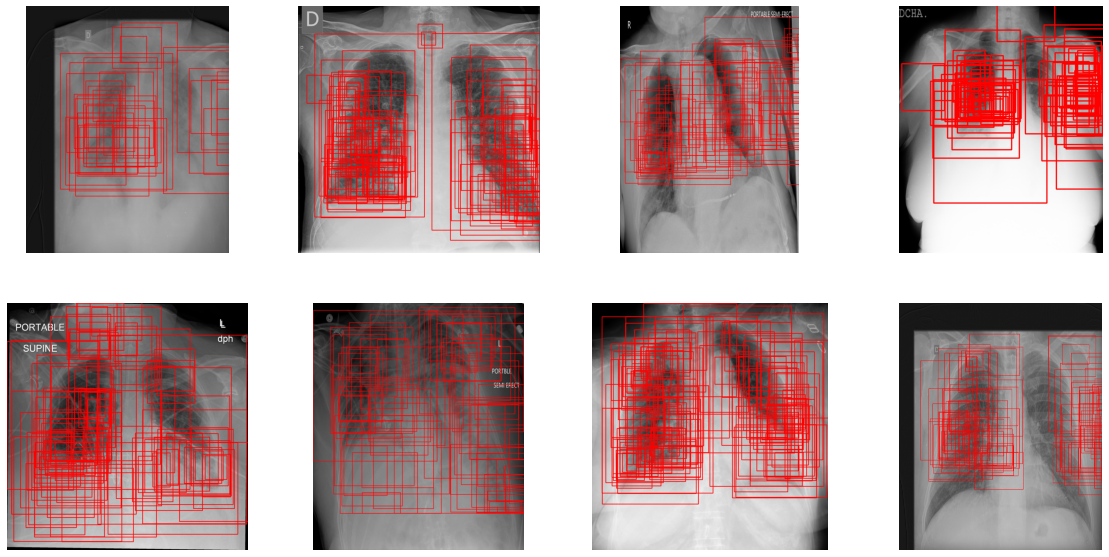

In [17]:
sample_images = []
count = 0
for Idx, bboxes, scores, labels in zip(image_ids, result_boxes, result_scores, result_labels):
    image_path = image_df.loc[image_df.image_id == Idx.split('_')[0]]['image_path'].values.item()
    image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
    h,w   = image_df.loc[image_df.image_id == Idx.split('_')[0], ['dim0', 'dim1']].values[0]
    image = cv2.resize(image, (h,w))
    for box,score,label in zip(bboxes, scores, labels):
        image = cv2.rectangle(image, (box[0], box[1]), (box[2], box[3]), color=(255,0,0), thickness=6)
    sample_images.append(image)
    if count == 10:
        break
    count += 1
    
show_images(sample_images, imsize=5, nrows=2, ncols=4)

In [18]:
predictions = write_submission(image_ids, result_boxes, result_scores, result_labels, score_thr=0.)
predictions.head(10)

,image_id,PredictionString
0,a29c5a68b07b_image,opacity 0.4814 1865 723 2739 1918 opacity 0.32...
1,9850b5470fd6_image,opacity 0.2100 323 645 1026 1875 opacity 0.207...
2,8d6dea06a032_image,opacity 0.3038 243 1270 1024 2188 opacity 0.28...
3,dfc5c09a50bc_image,opacity 0.2546 324 283 582 644 opacity 0.1853 ...
4,7230234e120a_image,opacity 0.4879 1450 1222 2175 1946 opacity 0.2...
5,f785f9c6bbf7_image,opacity 0.2116 229 338 1325 1740 opacity 0.135...
6,bb425c8a4aae_image,opacity 0.3232 1518 995 2112 1715 opacity 0.16...
7,5a0de0207028_image,opacity 0.2508 3105 1556 3941 2914 opacity 0.1...
8,9f6cc74b0062_image,opacity 0.2846 1427 1430 2249 2150 opacity 0.2...
9,e8b4525ec41f_image,opacity 0.2786 456 1542 1085 2047 opacity 0.19...


In [19]:
!rm -r /kaggle/working/

rm: cannot remove '/kaggle/working/': Device or resource busy


In [20]:
predictions.to_csv('effdet3_sub_iou@0.6.csv', index=False)